In [3]:
import kagglehub
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [ ]:
def read_data(type = 'sample'):
    """Read data set into a dataframe

    Args:
        type (str, optional): _description_. Defaults to 'sample', reading the sample data(2000,27),
        if 'complete', then read the whole (20000, 27) data set
    """
    data_path = "/Users/gufeng/2024_Fall/dasc6810/6810 Final project/data"
    if type == 'sample':
        data = pd.read_csv(data_path + "/sampled_df_trian.csv", index_col=0)
    elif type == 'complete':
        data = pd.read_csv(data_path + "/raw_data.csv").drop("Unnamed: 0", axis = 1)
    return data     

In [298]:
sample_data = read_data()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def _plot_numerical_distribution(dataframe, plot_type='hist', des_string=False, y=None):
    """
    Quickly draw plots for all columns in a dataframe.
    
    Args:
        dataframe (pd.DataFrame): A pandas dataframe where all columns are numerical.
        plot_type (str): The type of plots to draw. Options: 'hist', 'reg', 'box'.
        des_string (bool): Whether or not to add sample statistics to the plots.
        y (str): If plot_type is 'reg', the corresponding dependent variable.
    """
    # Only apply on the numerical columns
    dataframe = dataframe.select_dtypes(include=['number'])

    # Descriptive stats function
    def stats_descriptive_string(series):
        """Receive a series and return a string of common statistical features."""
        des_series = series.describe()[1:3].round().astype("str")
        des_string = ''
        for feature, value in zip(des_series.index, des_series):
            des_string += feature
            des_string += ": "
            des_string += value
            des_string += "\n"
        return des_string

    # Add descriptive text to the plot
    def add_text(ax, text):
        ax.text(
            0.95, 0.95,  # X and Y positions (normalized to the axes, 1 is the top/right)
            text,  # The text to display
            transform=ax.transAxes,  # Use axes coordinates
            ha="right",  # Horizontal alignment
            va="top",  # Vertical alignment
            fontsize=10,  # Text size
            color="red"  # Text color
        )

    # Plot based on the type
    def _plot(plot_type=plot_type):
        if plot_type == "hist":
            sns.histplot(dataframe[var], kde=True, ax=ax)
        elif plot_type == 'reg' and y is not None:
            sns.regplot(data=dataframe, x=var, y=y, ax=ax, scatter_kws={'alpha': 0.6})
        elif plot_type == 'box':
            sns.boxplot(data=dataframe, x=var, ax=ax)

    # Ensure the input data is sufficient
    if plot_type == 'reg' and y is None:
        raise ValueError("Please provide a dependent variable (y) for regplot.")

    # Set a clean theme
    sns.set_theme(style="whitegrid")

    variable_number = dataframe.shape[1]
    ncol = 5
    nrow = (variable_number - 1) // ncol + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 12))
    
    for var, ax in zip(dataframe.columns, axes.flatten()):
        _plot()
        if des_string:
            add_text(ax, stats_descriptive_string(dataframe[var]))

    # Remove any empty subplots
    for ax in axes.flatten()[variable_number:]:
        ax.set_visible(False)

    plt.tight_layout()

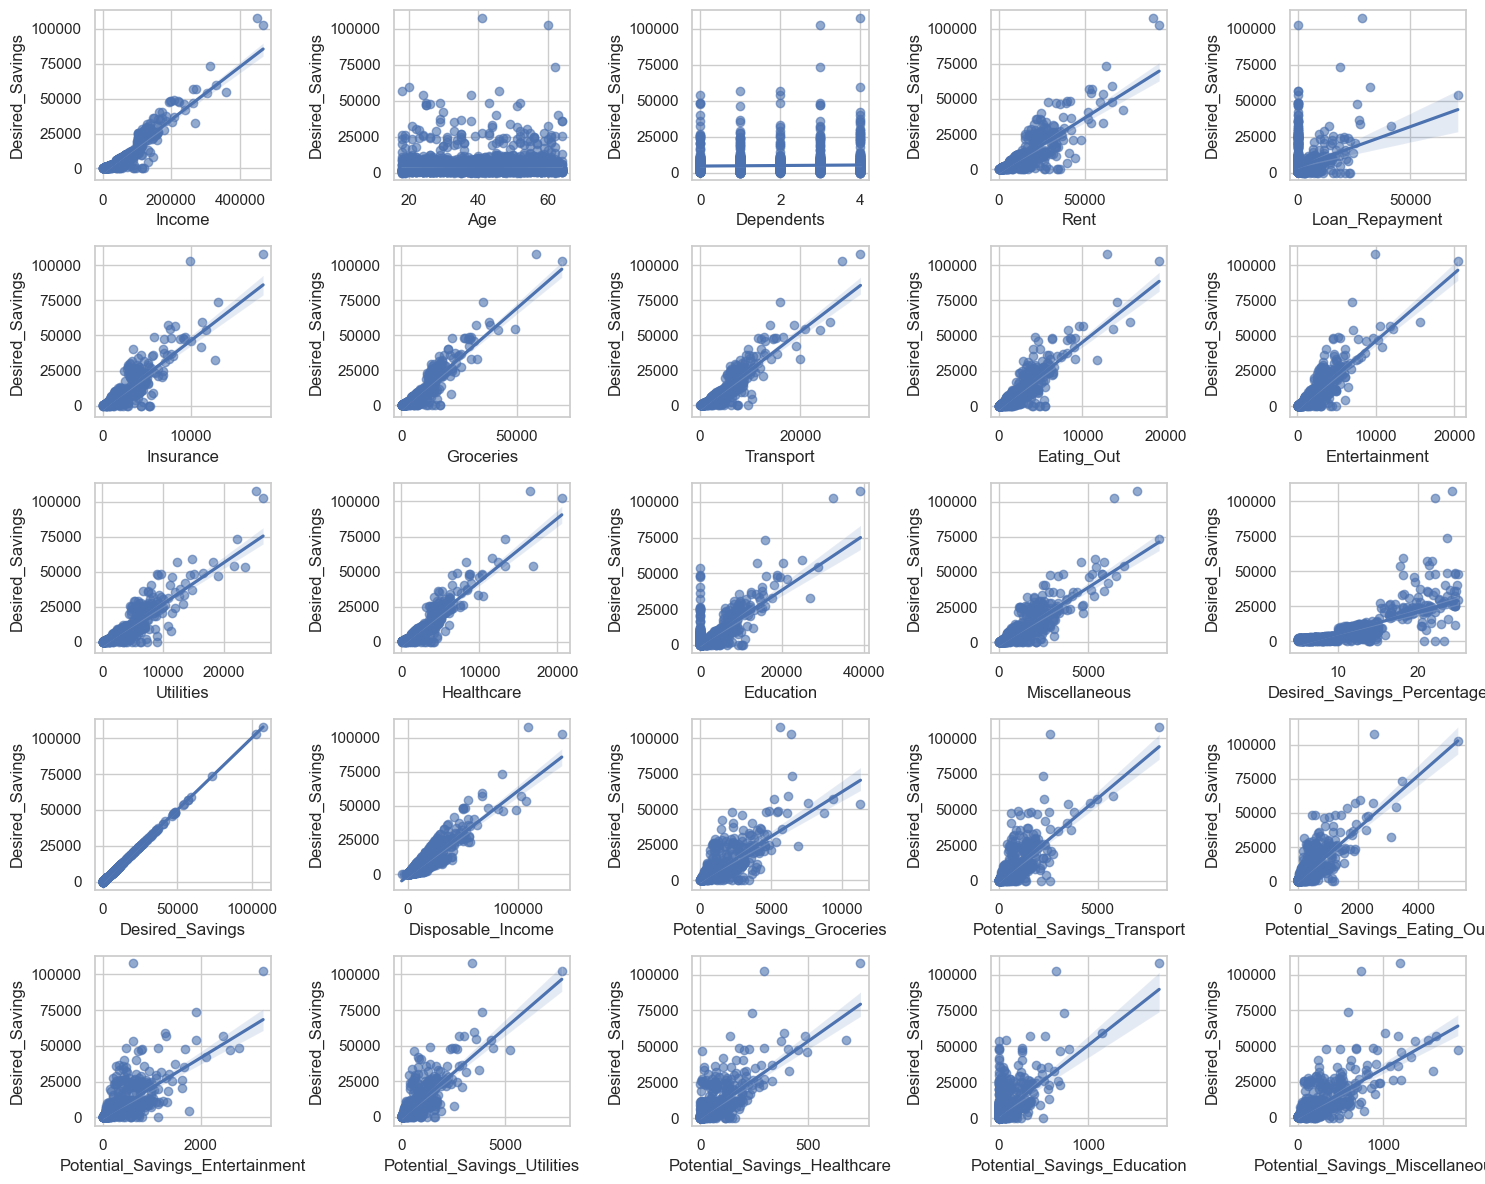

In [12]:
_plot_numerical_distribution(sample_data, 'reg', y = 'Desired_Savings')

In [115]:
# now, let us try to create the pipeline by sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import \
StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [16]:
# have a look at the column names
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 10650 to 11018
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Income                           1800 non-null   float64
 1   Age                              1800 non-null   int64  
 2   Dependents                       1800 non-null   int64  
 3   Occupation                       1800 non-null   object 
 4   City_Tier                        1800 non-null   object 
 5   Rent                             1800 non-null   float64
 6   Loan_Repayment                   1800 non-null   float64
 7   Insurance                        1800 non-null   float64
 8   Groceries                        1800 non-null   float64
 9   Transport                        1800 non-null   float64
 10  Eating_Out                       1800 non-null   float64
 11  Entertainment                    1800 non-null   float64
 12  Utilities           

In [20]:
# distinguish the object and numerical columns
# numerical_features = sample_data.select_dtypes(include=['number']).columns.values
# string_features = sample_data.select_dtypes(include = ['object']).columns.values
# print(numerical_features)
# print(string_features)

['Income' 'Age' 'Dependents' 'Rent' 'Loan_Repayment' 'Insurance'
 'Groceries' 'Transport' 'Eating_Out' 'Entertainment' 'Utilities'
 'Healthcare' 'Education' 'Miscellaneous' 'Desired_Savings_Percentage'
 'Desired_Savings' 'Disposable_Income' 'Potential_Savings_Groceries'
 'Potential_Savings_Transport' 'Potential_Savings_Eating_Out'
 'Potential_Savings_Entertainment' 'Potential_Savings_Utilities'
 'Potential_Savings_Healthcare' 'Potential_Savings_Education'
 'Potential_Savings_Miscellaneous']
['Occupation' 'City_Tier']


In [477]:

# 1. Impute the missing values
impute_missing = ColumnTransformer([
    ("num_", KNNImputer(n_neighbors = 5, weights = 'distance'), make_column_selector(dtype_include = np.number))
    ,("cat1_", SimpleImputer(strategy = 'constant', fill_value = 'Unknown'), make_column_selector(dtype_include = object))
    ,("cat2_", SimpleImputer(strategy = 'constant', fill_value = 'Unknown'), make_column_selector(dtype_include = "string"))
])

In [158]:
# Fit and transform the data
transformed_data = impute_missing.fit_transform(sample_data)

# Retrieve the transformed column names
column_names = impute_missing.get_feature_names_out()

# Convert to a pandas DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=column_names)

# Output the DataFrame
transformed_df
# impute_missing.fit_transform(sample_data)

,num___Income,num___Age,num___Dependents,num___Rent,num___Loan_Repayment,num___Insurance,num___Groceries,num___Transport,num___Eating_Out,num___Entertainment,...,num___Potential_Savings_Groceries,num___Potential_Savings_Transport,num___Potential_Savings_Eating_Out,num___Potential_Savings_Entertainment,num___Potential_Savings_Utilities,num___Potential_Savings_Healthcare,num___Potential_Savings_Education,num___Potential_Savings_Miscellaneous,cat___Occupation,cat___City_Tier
0,25170.370398,23.0,4.0,5034.07408,0.0,571.826422,3124.233037,2002.825335,758.940472,815.723681,...,489.438552,335.618024,151.461379,144.63917,424.443976,34.479267,86.614411,104.553049,Retired,Tier_2
1,21623.299874,48.0,1.0,4324.659975,0.0,468.588277,2549.652415,1454.719436,813.946784,947.011991,...,453.756847,415.875928,219.801547,262.835575,178.933757,13.450726,25.245161,23.969373,Self_Employed,Tier_2
2,40819.932938,30.0,2.0,8163.986588,4492.850514,1202.675988,6060.606479,3013.018468,1278.091388,1736.638415,...,560.173493,824.411531,106.539024,261.950624,357.910093,18.050821,64.520646,94.39212,Retired,Tier_2
3,33836.242989,37.0,4.0,6767.248598,2446.775991,1314.658328,4924.689606,1691.818821,1333.902755,1503.010364,...,1073.913744,215.4416,261.652708,163.463485,369.002792,21.216537,11.4257,157.792951,Retired,Tier_2
4,28898.734885,22.0,2.0,5779.746977,0.0,697.13109,3498.144912,2168.36908,603.538061,1029.325587,...,898.195322,360.654021,120.07861,284.046353,464.304814,24.008847,40.088449,105.061996,Student,Tier_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,64110.183685,33.0,2.0,19233.055105,3736.997491,1644.315706,9100.508294,4141.46797,1860.48188,1815.507375,...,1734.988247,732.134758,316.55397,449.099207,251.007282,37.787076,150.064834,277.093161,Self_Employed,Tier_1
1796,37646.041299,52.0,3.0,5646.906195,0.0,1433.246882,4424.016329,2355.098783,1136.511125,1347.304365,...,303.150817,321.162478,115.247268,87.155383,137.909699,30.920209,123.84725,253.066112,Student,Tier_3
1797,39137.241388,55.0,0.0,7827.448278,0.0,1904.569716,5381.468702,2499.655693,1904.444301,1608.484479,...,667.882921,165.370952,495.631339,245.125367,124.870783,30.607524,0.0,78.698119,Retired,Tier_2
1798,79767.735925,47.0,3.0,23930.320777,0.0,3227.123998,9283.224079,5981.936432,3778.482885,2201.36136,...,1834.456723,762.171566,1046.470036,120.461172,1312.091885,2.675459,333.519589,270.991735,Professional,Tier_1


In [434]:
# 2. transform the features
feature_transformer = ColumnTransformer([
        ("PTS", PowerTransformer(method = 'yeo-johnson'), make_column_selector(dtype_include = np.number)),
        # ('scaler', RobustScaler(), make_column_selector(dtype_include = np.number)), # new change, scale the data
        ('OneHot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), make_column_selector(dtype_include = 'string'))
    ]
    )

In [160]:
feature_transformer.fit_transform(sample_data)
feature_transformer.get_feature_names_out()

array(['PTS__Income', 'PTS__Age', 'PTS__Dependents', 'PTS__Rent',
       'PTS__Loan_Repayment', 'PTS__Insurance', 'PTS__Groceries',
       'PTS__Transport', 'PTS__Eating_Out', 'PTS__Entertainment',
       'PTS__Utilities', 'PTS__Healthcare', 'PTS__Education',
       'PTS__Miscellaneous', 'PTS__Desired_Savings_Percentage',
       'PTS__Desired_Savings', 'PTS__Disposable_Income',
       'PTS__Potential_Savings_Groceries',
       'PTS__Potential_Savings_Transport',
       'PTS__Potential_Savings_Eating_Out',
       'PTS__Potential_Savings_Entertainment',
       'PTS__Potential_Savings_Utilities',
       'PTS__Potential_Savings_Healthcare',
       'PTS__Potential_Savings_Education',
       'PTS__Potential_Savings_Miscellaneous'], dtype=object)

In [424]:
# define a function to use pipline on a dataframe 
# and then covert it back to a dataframe
def _transform_data(data, transformer):
    """Apply a pipline on a dataframe and return the transformed array
    back to a dataframe with corresponding column names

    Args:
        data (_type_): _description_
        transformer (_type_): _description_

    Returns:
        _type_: _description_
    """
    transformed_array = transformer.fit_transform(data)
    column_names = transformer.get_feature_names_out()
    # Convert to a pandas DataFrame
    transformed_df = pd.DataFrame(transformed_array, columns=column_names)
    # update the date types in the dataframe
    transformed_df = transformed_df.convert_dtypes()
    # Output the DataFrame
    return transformed_df

In [163]:
transformed_data_1 = _transform_data(sample_data, impute_missing)
transformed_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   num___Income                           1800 non-null   Float64
 1   num___Age                              1800 non-null   Int64  
 2   num___Dependents                       1800 non-null   Int64  
 3   num___Rent                             1800 non-null   Float64
 4   num___Loan_Repayment                   1800 non-null   Float64
 5   num___Insurance                        1800 non-null   Float64
 6   num___Groceries                        1800 non-null   Float64
 7   num___Transport                        1800 non-null   Float64
 8   num___Eating_Out                       1800 non-null   Float64
 9   num___Entertainment                    1800 non-null   Float64
 10  num___Utilities                        1800 non-null   Float64
 11  num_

In [176]:
transformed_data_2 = _transform_data(transformed_data_1, feature_transformer)
transformed_data_2.head()

,PTS__num___Income,PTS__num___Age,PTS__num___Dependents,PTS__num___Rent,PTS__num___Loan_Repayment,PTS__num___Insurance,PTS__num___Groceries,PTS__num___Transport,PTS__num___Eating_Out,PTS__num___Entertainment,...,scaler__num___Potential_Savings_Entertainment,scaler__num___Potential_Savings_Utilities,scaler__num___Potential_Savings_Healthcare,scaler__num___Potential_Savings_Education,scaler__num___Potential_Savings_Miscellaneous,OneHot__cat___Occupation_Retired,OneHot__cat___Occupation_Self_Employed,OneHot__cat___Occupation_Student,OneHot__cat___City_Tier_Tier_2,OneHot__cat___City_Tier_Tier_3
0,-0.207455,-1.361091,1.347075,-0.28675,-0.785034,-0.662866,-0.205875,0.042818,-0.33405,-0.259492,...,-0.066558,0.36467,0.22291,0.711946,0.079214,1,0,0,1,0
1,-0.391527,0.537011,-0.597253,-0.462296,-0.785034,-0.889719,-0.449433,-0.338644,-0.253333,-0.085705,...,0.464606,-0.26596,-0.259489,-0.111048,-0.532026,0,1,0,1,0
2,0.384005,-0.799105,0.12748,0.278354,1.306906,0.197665,0.593821,0.535319,0.269493,0.632464,...,0.460629,0.193768,-0.153962,0.415657,0.002142,1,0,0,1,0
3,0.153466,-0.263798,1.347075,0.057901,1.240068,0.302134,0.342416,-0.158962,0.319221,0.459592,...,0.018037,0.222261,-0.081339,-0.296374,0.483048,1,0,0,1,0
4,-0.039345,-1.444056,0.12748,-0.126291,-0.785034,-0.435605,-0.070052,0.138127,-0.597671,0.01186,...,0.559925,0.467059,-0.017283,0.088009,0.083075,0,0,1,1,0


In [188]:
transformed_data = sample_data
for transformer in [impute_missing, feature_transformer]: 
    transformed_data = _transform_data(transformed_data, transformer)
transformed_data.head()

,PTS__num___Income,PTS__num___Age,PTS__num___Dependents,PTS__num___Rent,PTS__num___Loan_Repayment,PTS__num___Insurance,PTS__num___Groceries,PTS__num___Transport,PTS__num___Eating_Out,PTS__num___Entertainment,...,scaler__num___Potential_Savings_Entertainment,scaler__num___Potential_Savings_Utilities,scaler__num___Potential_Savings_Healthcare,scaler__num___Potential_Savings_Education,scaler__num___Potential_Savings_Miscellaneous,OneHot__cat___Occupation_Retired,OneHot__cat___Occupation_Self_Employed,OneHot__cat___Occupation_Student,OneHot__cat___City_Tier_Tier_2,OneHot__cat___City_Tier_Tier_3
0,-0.207455,-1.361091,1.347075,-0.28675,-0.785034,-0.662866,-0.205875,0.042818,-0.33405,-0.259492,...,-0.066558,0.36467,0.22291,0.711946,0.079214,1,0,0,1,0
1,-0.391527,0.537011,-0.597253,-0.462296,-0.785034,-0.889719,-0.449433,-0.338644,-0.253333,-0.085705,...,0.464606,-0.26596,-0.259489,-0.111048,-0.532026,0,1,0,1,0
2,0.384005,-0.799105,0.12748,0.278354,1.306906,0.197665,0.593821,0.535319,0.269493,0.632464,...,0.460629,0.193768,-0.153962,0.415657,0.002142,1,0,0,1,0
3,0.153466,-0.263798,1.347075,0.057901,1.240068,0.302134,0.342416,-0.158962,0.319221,0.459592,...,0.018037,0.222261,-0.081339,-0.296374,0.483048,1,0,0,1,0
4,-0.039345,-1.444056,0.12748,-0.126291,-0.785034,-0.435605,-0.070052,0.138127,-0.597671,0.01186,...,0.559925,0.467059,-0.017283,0.088009,0.083075,0,0,1,1,0


In [351]:
# create a visual pipeline 
pipe_line = Pipeline([
    ("first", impute_missing),
    ("second", feature_transformer)  
])

In [352]:
from sklearn import set_config
set_config(display="diagram")
pipe_line

Pipeline(steps=[('first',
                 ColumnTransformer(transformers=[('num_',
                                                  KNNImputer(weights='distance'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228cf10>),
                                                 ('cat_',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228d2d0>)])),
                ('second',
                 ColumnTransformer(t...),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x301ce7cd0>),
                                                 ('scaler', RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x303080750>),
                                                 ('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x303083250>)]))])

In [197]:
# store the pipeline figure
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
_ = pipe_line
plt.savefig("pipeline_diagram.png", dpi=300)

<Figure size 1000x600 with 0 Axes>

In [209]:
def detect_observations_iqr(series, lower_quantil=0.25, upper_quantil=0.75, type='outlier', length_of_fence=0):
    """
    Detect observations in a pandas Series based on the Interquartile Range (IQR) method.
    
    Parameters:
        series (pd.Series): Input data series to analyze.
        lower_quantil (float): Lower quantile threshold (default is 0.25 for Q1).
        upper_quantil (float): Upper quantile threshold (default is 0.75 for Q3).
        type (str): Type of observations to detect. 
                    Use 'outlier' to find outliers or 'inlier' to find inliers. Default is 'outlier'.
        length_of_fence (float): Multiplier for the IQR to extend the fence for outlier/inlier detection. Default is 0.

    Returns:
        pd.Series: A pandas Series containing the detected outliers or inliers.
        tuple: A tuple containing the lower and upper bounds used for detection.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = series.quantile(lower_quantil)
    Q3 = series.quantile(upper_quantil)
    IQR = Q3 - Q1

    # Define bounds for outliers/inliers
    lower_bound = Q1 - length_of_fence * IQR
    upper_bound = Q3 + length_of_fence * IQR

    # Detect outliers or inliers
    if type == 'outlier':
        observations = series[(series < lower_bound) | (series > upper_bound)]
    elif type == 'inlier':
        observations = series[(series >= lower_bound) & (series <= upper_bound)]
    else:
        raise ValueError("Parameter 'type' must be either 'outlier' or 'inlier'.")

    return observations


def filter_df_by_quantile(dataframe, column, lower_quantile=0.25, upper_quantile=0.75, type='outlier'):
    """
    Filter rows in a DataFrame based on the quantiles of a specified column.
    
    Parameters:
        dataframe (pd.DataFrame): The input DataFrame to filter.
        column (str): The name of the column to analyze for quantiles.
        lower_quantile (float): Lower quantile threshold (default is 0.25 for Q1).
        upper_quantile (float): Upper quantile threshold (default is 0.75 for Q3).
        type (str): Type of rows to retain based on the quantiles.
                    Use 'outlier' to keep rows with outliers or 'inlier' to keep rows with inliers. Default is 'outlier'.

    Returns:
        pd.DataFrame: A filtered DataFrame containing rows matching the criteria.
    """
    # Detect relevant observations based on quantiles
    filtered_series = detect_observations_iqr(dataframe[column], lower_quantile, upper_quantile, type)

    # Filter the DataFrame rows based on the detected observations
    filtered_df = dataframe.loc[filtered_series.index, :]

    return filtered_df

In [210]:
detect_observations_iqr(sample_data['Income'], 0.1, 0.9)

16441     87318.279755
19393    127038.813164
16796      9722.654465
17553    115396.613249
9119      90293.493655
             ...      
5348       6062.281753
4028     107773.076310
9416     120112.757233
12044    114229.244960
8918       7606.882314
Name: Income, Length: 360, dtype: float64

In [211]:
filter_df_by_quantile(sample_data, 'Income', 0.1, 0.9)

,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
16441,87318.279755,22,3,Retired,Tier_1,26195.483927,0.000000,2787.561001,11943.514906,6153.906824,...,11189.089508,16544.358607,1264.277746,1665.597675,963.696140,605.078242,953.657436,65.993708,260.357511,349.710152
19393,127038.813164,47,3,Self_Employed,Tier_3,19055.821975,0.000000,3893.533553,19007.331316,9818.773932,...,24425.364868,33552.142981,4861.133227,1367.851011,619.211135,525.666144,1886.847345,131.146809,267.817651,963.786250
16796,9722.654465,45,0,Professional,Tier_1,2916.796340,0.000000,332.827702,1264.253506,654.068858,...,819.119587,3011.872680,131.756363,111.161179,43.120500,64.207611,133.525022,9.991875,0.000000,23.588349
17553,115396.613249,61,4,Professional,Tier_2,23079.322650,21514.099489,5747.924901,14362.214291,8115.701569,...,9323.906121,9323.906121,3923.556731,735.568560,569.376845,789.622360,1413.926616,46.807027,461.122062,591.232156
9119,90293.493655,45,1,Student,Tier_2,18058.698731,0.000000,3634.554709,11378.097389,6031.114922,...,13408.701618,25801.074637,2055.870699,656.353672,892.691541,367.862287,1670.405786,106.842029,148.393487,126.715120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,6062.281753,35,2,Student,Tier_1,1818.684526,0.000000,155.914259,763.477581,397.349541,...,340.122457,1330.279720,61.296178,101.150035,51.849591,64.322390,122.534128,2.491938,16.004662,15.358568
4028,107773.076310,36,0,Student,Tier_1,32331.922893,11556.630795,3246.334959,11673.186181,7861.749005,...,20473.480769,20473.480769,1036.814801,1673.302031,934.571156,780.564782,1594.264938,127.348959,0.000000,454.594669
9416,120112.757233,33,3,Retired,Tier_2,24022.551447,14507.389749,4682.398991,15661.273970,9300.589484,...,19098.252773,19098.252773,4187.690375,2760.746139,547.619883,1037.325967,593.697508,192.222794,98.376427,354.104621
12044,114229.244960,43,3,Professional,Tier_1,34268.773488,0.000000,3347.310200,13459.554940,9064.712289,...,26170.263091,26170.263091,1009.989678,2097.059522,1000.527442,627.829601,1727.359850,9.781285,343.908303,532.495161


In [212]:
# check the size of a df
sample_data.size

48600

In [458]:
import pandas as pd
import numpy as np

def introduce_missing_values(dataframe, missing_fraction=0.1, random_seed=None):
    """
    Randomly remove values from a DataFrame to introduce missing values.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        missing_fraction (float): Fraction of values to be removed (default is 0.1).
                                  Must be between 0 and 1.
        random_seed (int): Random seed for reproducibility (default is None).

    Returns:
        pd.DataFrame: A new DataFrame with missing values introduced.
    """
    if not 0 <= missing_fraction <= 1:
        raise ValueError("missing_fraction must be between 0 and 1.")
    
    # Convert DataFrame to float to handle NaN
    df_with_missing = dataframe.copy()
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Calculate the total number of values and the number of missing values
    total_values = df_with_missing.size
    num_missing = int(total_values * missing_fraction)
    
    # Randomly select indices for missing values
    missing_indices = np.random.choice(total_values, num_missing, replace=False)
    
    # Flatten the DataFrame and set selected indices to NaN
    flat_values = df_with_missing.values.flatten()
    flat_values[missing_indices] = None
    
    # Reshape the flattened array back to the original DataFrame shape
    df_with_missing = pd.DataFrame(flat_values.reshape(dataframe.shape), 
                                   columns=dataframe.columns, 
                                   index=dataframe.index)
    
    return df_with_missing

In [225]:
def check_dataframe_info(df):
    """
    Quickly check the data types and whether there are missing values in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to check.

    Returns:
        pd.DataFrame: A summary of column data types, missing values, and missing value percentages.
    """
    # Get data types
    data_types = df.dtypes

    # Count missing values
    missing_values = df.isnull().sum()

    # Calculate percentage of missing values
    missing_percentage = (missing_values / len(df)) * 100

    # Create a summary DataFrame
    summary = pd.DataFrame({
        "Data Type": data_types,
        "Missing Values": missing_values,
        "Missing Percentage (%)": missing_percentage
    }).sort_values(by="Missing Values", ascending=False)

    return summary

In [295]:
sample_data = introduce_missing_values(sample_data)
check_dataframe_info(sample_data)

,Data Type,Missing Values,Missing Percentage (%)
Dependents,object,198,11.000000
Occupation,object,196,10.888889
Desired_Savings_Percentage,object,195,10.833333
Utilities,object,194,10.777778
Potential_Savings_Transport,object,192,10.666667
Potential_Savings_Entertainment,object,191,10.611111
Miscellaneous,object,188,10.444444
City_Tier,object,187,10.388889
Groceries,object,187,10.388889
Potential_Savings_Groceries,object,186,10.333333


In [297]:
sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 10650 to 11018
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Income                           1616 non-null   object
 1   Age                              1622 non-null   object
 2   Dependents                       1602 non-null   object
 3   Occupation                       1604 non-null   object
 4   City_Tier                        1613 non-null   object
 5   Rent                             1634 non-null   object
 6   Loan_Repayment                   1619 non-null   object
 7   Insurance                        1624 non-null   object
 8   Groceries                        1613 non-null   object
 9   Transport                        1629 non-null   object
 10  Eating_Out                       1621 non-null   object
 11  Entertainment                    1648 non-null   object
 12  Utilities                        1

In [ ]:
# read the complete sample data again
sample_data = read_data()

In [304]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification

raw_X = sample_data.drop(columns='Desired_Savings')
X = raw_X.copy()
# transform the original X data
for transformer in [impute_missing, feature_transformer]:
    X = _transform_data(X, transformer)

y = sample_data["Desired_Savings"]

In [313]:
# try the cross_validate function to assess the performance of models
test_model = RandomForestRegressor(random_state=42)
scores = cross_validate(test_model, 
                        X, y, 
                        cv = 3, 
                        return_train_score=True,
                        scoring = ['r2', 'neg_mean_squared_error'])

In [344]:
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor



# Create a list of base models, train and score them on a data set

base_models = [
    
                ("LinearRegression", LinearRegression()),
                ("Ridge", Ridge()),
                ("ElasticNet", ElasticNet()),
                ("DecisionTreeRegressor", DecisionTreeRegressor()),
                ("SVR", SVR()),
                ("RandomForestRegressor", RandomForestRegressor()),
            ]

ModuleNotFoundError: No module named 'xgboost'

In [327]:
# Define custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define custom log-likelihood scorer
def log_likelihood(y_true, y_pred):
    residual = y_true - y_pred
    sigma2 = np.var(residual)
    n = len(y_true)
    ll = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return ll

loglik_scorer = make_scorer(log_likelihood, greater_is_better=True)

In [341]:
# Scoring dictionary
scoring = {
    'MSE': 'neg_mean_squared_error',  # Built-in scorer
    'R2': 'r2',                       # Built-in scorer
    'RMSE': rmse_scorer,              # Custom scorer
    'Log-Lik': loglik_scorer,          # Custom scorer
}

# Model
fold_times = 5

model_name = []
model_mean_test_MSE = []
model_mean_test_RMSE = []
model_mean_test_R2 = []
model_mean_test_loglik = []

# Cross-validate
for name, model in base_models:
    scores = cross_validate(model,
                            X, y, 
                            cv = fold_times,
                            scoring=scoring)
    model_name.append(name)
    
    model_mean_test_MSE.append(-np.mean(scores["test_MSE"]))
    model_mean_test_RMSE.append(-np.mean(scores["test_RMSE"]))
    model_mean_test_R2.append(np.mean(scores["test_R2"]))
    model_mean_test_loglik.append(np.mean(scores["test_Log-Lik"]))

In [343]:
# Create DataFrame from lists
models_cross_val_results_df = pd.DataFrame(
    {"Model": model_name,
     "Mean_Test_MSE": model_mean_test_MSE,
     "Mean_Test_RMSE": model_mean_test_RMSE,
     "Mean_Test_R2": model_mean_test_R2,
     "Mean_Test_Log-Lik": model_mean_test_loglik})
models_cross_val_results_df.round(4)

,Model,Mean_Test_MSE,Mean_Test_RMSE,Mean_Test_R2,Mean_Test_Log-Lik
0,LinearRegression,2.811438e+06,1650.5358,0.9506,-3172.2390
1,Ridge,2.764091e+06,1635.6588,0.9513,-3168.8755
2,ElasticNet,4.215837e+06,2026.0392,0.9276,-3246.3238
3,DecisionTreeRegressor,3.256676e+06,1602.4171,0.9562,-3120.0717
4,SVR,7.031083e+07,8169.2332,-0.1123,-3720.3678
5,RandomForestRegressor,2.731340e+06,1500.2479,0.9634,-3098.4969


In [348]:
# by observing, the LinearRegression and RandomForestRegressor are the two models perform better
# now, use GridSearchCV class to search for the best parameters for them
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
}

# Define parameter grids
param_grids = {
    "LinearRegression": {
        "fit_intercept": [True, False],
        "positive": [True, False],  # If normalize is not deprecated in your Scikit-learn version
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
}

In [358]:
# Define a scorer (using negative mean squared error for minimization)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Loop through models and parameter grids
best_models = {}
for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring=rmse_scorer,
        cv=5,  # Number of folds in cross-validation
        verbose=2,
        n_jobs=-1,  # Use all available cores
    )
    grid_search.fit(X, y)  # Replace with your training data
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Running GridSearchCV for LinearRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s

[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END ..................fit_intercept=True, positive=True; total time=   0.1s
[CV] END .................fit_intercept=False, positive=True; total time=   0.0s
[CV] END .................fit_intercept=True, positive=False; total time=   0.0s
[CV] END .................fit_intercept=False, positive=True; total time=   0.0s
[CV]

In [359]:
grid_search.best_score_

-1460.4022624482996

In [360]:
# create a visual pipeline 
pipe_line = Pipeline([
    ("first", impute_missing),
    ("second", feature_transformer),
    ('final', grid_search)
])

pipe_line

Pipeline(steps=[('first',
                 ColumnTransformer(transformers=[('num_',
                                                  KNNImputer(weights='distance'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228cf10>),
                                                 ('cat_',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228d2d0>)])),
                ('second',
                 ColumnTransformer(t...
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x303083250>)])),
                ('final',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 10, 20],
                                          'min_samples_split': [2, 5],
                                          'n_estimators': [50, 100, 200]},
                              scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                              verbose=2))])

In [361]:
# assess the scores for this single model 
scores = cross_validate(RandomForestRegressor(max_depth=10),
                            X, y, 
                            cv = fold_times,
                            scoring=scoring)

In [363]:
scores = pd.DataFrame(scores)
scores.head()

,fit_time,score_time,test_MSE,test_R2,test_RMSE,test_Log-Lik
0,2.957133,0.018578,-3.798316e+06,0.962753,-1948.926770,-3237.579750
1,2.643979,0.006311,-2.205177e+06,0.965945,-1484.983733,-3139.782480
2,2.802229,0.012681,-3.735324e+05,0.985540,-611.172984,-2820.151590
3,2.720368,0.012168,-5.470782e+05,0.986854,-739.647357,-2888.245321
4,2.430584,0.006525,-6.253042e+06,0.924084,-2500.608410,-3327.030786


In [365]:
best_model = RandomForestRegressor(max_depth=10)
best_model.fit(X, y)

RandomForestRegressor(max_depth=10)

In [373]:
# create a visual pipeline 
pipe_line = Pipeline([
    ("first", impute_missing),
    ("second", feature_transformer),
    ('final', grid_search),
    ("last", best_model)
])

pipe_line


Pipeline(steps=[('first',
                 ColumnTransformer(transformers=[('num_',
                                                  KNNImputer(weights='distance'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228cf10>),
                                                 ('cat_',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30228d2d0>)])),
                ('second',
                 ColumnTransformer(t...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x303083250>)])),
                ('final',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 10, 20],
                                          'min_samples_split': [2, 5],
                                          'n_estimators': [50, 100, 200]},
                              scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                              verbose=2)),
                ('last', RandomForestRegressor(max_depth=10))])

In [403]:
def base_model_list(basemodels):
    """Create a list in which the elements are tuples in ('name', <estimator>)
    form. There are six benchmark models to compare.
    

    Returns:
        basemodel(lists): lists of tuple of '('name', <estimator>)' form, added as an estimator
        to be compared with the benchmarks
    """
    base_models = [
        
                    ("LinearRegression", LinearRegression()),
                    ("Ridge", Ridge()),
                    ("ElasticNet", ElasticNet()),
                    ("DecisionTreeRegressor", DecisionTreeRegressor()),
                    ("SVR", SVR()),
                    ("RandomForestRegressor", RandomForestRegressor()),
                ]
    base_models.extend(basemodels)
    return base_models

In [404]:
new_models = [("name1", LinearRegression()),
              ("name2", LinearRegression())]
base_model_list(new_models)

[('LinearRegression', LinearRegression()),
 ('Ridge', Ridge()),
 ('ElasticNet', ElasticNet()),
 ('DecisionTreeRegressor', DecisionTreeRegressor()),
 ('SVR', SVR()),
 ('RandomForestRegressor', RandomForestRegressor()),
 ('name1', LinearRegression()),
 ('name2', LinearRegression())]

In [453]:
def _transform_data(data, transformer):
    """Apply a pipline on a dataframe and return the transformed array
    back to a dataframe with corresponding column names

    Args:
        data (_type_): _description_
        transformer (_type_): _description_

    Returns:`
        _type_: _description_
    """
    transformed_array = transformer.fit_transform(data)
    column_names = transformer.get_feature_names_out()
    # Convert to a pandas DataFrame
    transformed_df = pd.DataFrame(transformed_array, columns=column_names)
    # update the date types in the dataframe
    transformed_df = transformed_df.convert_dtypes()
    # Output the DataFrame
    return transformed_df

In [484]:
test_df = sample_data.copy()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1800 entries, 10650 to 11018
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Income                           1800 non-null   float64
 1   Age                              1800 non-null   int64  
 2   Dependents                       1800 non-null   int64  
 3   Occupation                       1800 non-null   object 
 4   City_Tier                        1800 non-null   object 
 5   Rent                             1800 non-null   float64
 6   Loan_Repayment                   1800 non-null   float64
 7   Insurance                        1800 non-null   float64
 8   Groceries                        1800 non-null   float64
 9   Transport                        1800 non-null   float64
 10  Eating_Out                       1800 non-null   float64
 11  Entertainment                    1800 non-null   float64
 12  Utilities           

In [485]:
for transformer in [impute_missing, feature_transformer]:
    test_df = _transform_data(test_df, transformer)

In [487]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   PTS__num___Income                           1800 non-null   Float64
 1   PTS__num___Age                              1800 non-null   Float64
 2   PTS__num___Dependents                       1800 non-null   Float64
 3   PTS__num___Rent                             1800 non-null   Float64
 4   PTS__num___Loan_Repayment                   1800 non-null   Float64
 5   PTS__num___Insurance                        1800 non-null   Float64
 6   PTS__num___Groceries                        1800 non-null   Float64
 7   PTS__num___Transport                        1800 non-null   Float64
 8   PTS__num___Eating_Out                       1800 non-null   Float64
 9   PTS__num___Entertainment                    1800 non-null   Float64
 10  PTS__num___U